<a href="https://colab.research.google.com/github/fred2167/Personal-Project/blob/master/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import time

to_float_cuda = {"dtype": torch.float32, "device":"cuda"}

In [2]:
transformer = transform.Compose([
                                transform.Resize(256),
                                transform.CenterCrop(224),
                                transform.ToTensor(),
                                transform.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset = torchvision.datasets.CIFAR10("./data",train=True, transform=transformer,download=True)
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)

dev_dataset = torchvision.datasets.CIFAR10("./data",train=False, transform=transformer,download=True)
devloader = torch.utils.data.DataLoader(dev_dataset,batch_size=64,shuffle=True,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


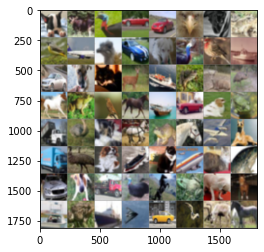

In [3]:
def imshow(img):
  img = img /2 +0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show

dataiter = iter(trainloader)
images, label = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [118]:
class SE_block (nn.Module):
  '''
  Squeeze and Excitation block
  Some channels may be more important than another, therefore create a weight for number
  of channels allow the network to prioritize different channels.
  Sigmoid is used to ensure the outputs are between 0 and 1.

  Inputs:
  - in_channel: num of channels for the input feature maps (after expand)
  - ratio: Used to reduce dimension in linear layers, original paper default value = 16
  - has_se: Equal Ture when MBConv kernel size is 5, otherwise False
  Outpus:
  - A weighted output with the same shape with input, if has_se == Flase, return identity

  Note:
  - Actual implementaion of SE paper use linear but EfficientNet used Conv2d with kernel size 1 with original input channels (before expand) * 0.25. 
    Here I convert in_channel back to number of channels before expansion and devide by 4 to match the implementation of EffcientNet as close as possible.
    However, I cant use Conv2d without major change after global average pooling. Therefore, I kept the linear layer.
    I suspect it make little difference between the two.
  '''
  def __init__(self,in_channel, channel_expand_factor, ratio= 4):
    super().__init__()

    intermediate_channel = int((in_channel / channel_expand_factor) // ratio)
    
    self.weights = nn.Sequential(
                                nn.AdaptiveAvgPool2d((1,1)),
                                nn.Flatten(),
                                nn.Linear(in_channel,intermediate_channel),
                                nn.ReLU(),
                                nn.Linear(intermediate_channel, in_channel),
                                nn.Sigmoid()
                                )

  def forward (self,x):
      return x * self.weights(x).unsqueeze(-1).unsqueeze(-1)

class MBConv_block(nn.Module):
  '''
  Inputs:
    - channel_expand_factor: channel expand coeffient within inverse bottleneck block
    - keepdim: if ture, keep dimention of input's width, and height the same for output
               if false, input height and width are downsample by a factor of 2 
  Note:
    - Convolution bias parameters are turned off for layer right before batchnorm, since batchnorm eliminate any biases affects
    - Actually implementation use Swish activation
  '''

  def __init__ (self, in_channel, out_channel, kernel_size, channel_expand_factor=6, keepdim=True):
    super().__init__()

    self.residual = keepdim and in_channel == out_channel

    intermidiate_channels = in_channel*channel_expand_factor
    pad = (kernel_size - 1) // 2

    # if keepdim, image size are not changing
    stride = 1 if keepdim else 2

    self.inv_bottleneck_block = nn.Sequential(
                                              nn.Conv2d(in_channel, intermidiate_channels, kernel_size=1, bias=False),
                                              nn.BatchNorm2d(intermidiate_channels),
                                              nn.ReLU(),
                                              nn.Conv2d(intermidiate_channels, intermidiate_channels, kernel_size, stride, pad, groups=intermidiate_channels, bias= False), # Depthwise Conv
                                              nn.BatchNorm2d(intermidiate_channels),
                                              nn.ReLU(),
                                              SE_block(intermidiate_channels, channel_expand_factor),
                                              nn.Conv2d(intermidiate_channels, out_channel, kernel_size=1, bias=False),
                                              nn.BatchNorm2d(out_channel),
                                              )
    

  def forward (self, x):
    
    output = self.inv_bottleneck_block(x)

    # dropout only using where there is a residual connection, drop rate is hard coded just as the original paper, it didn't change regardless of stages and model sizes
    if self.residual:
      return F.dropout(output, 0.2, self.training)  +  x
    else:
      return output


class MBConv_stage (nn.Module):

  def __init__(self, in_channel_, out_channel_, kernel_size_, channel_expand_factor_, num_layers_, stage_downsample_= True):
    super().__init__()

    module_list = nn.ModuleList()

    for i in range(num_layers_):
      cin = in_channel_ if i == 0 else out_channel_                             # first case where input channels equal actual inputs, otherwise it equals to output channels
      keepdim = False if i == num_layers_ - 1 and stage_downsample_ else True   # last case where we want to downsample the image width and height by a factor of 2 if stage_downsample_ = True
      
      module_list.append(MBConv_block(cin, out_channel_, kernel_size_, channel_expand_factor_, keepdim))

    self.stage = nn.Sequential(*module_list)
  def forward(self, x):
    return self.stage(x)



In [64]:
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

# Paper original helper function
def round_filters(filters, width_coefficient, depth_divisor= 8):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

In [120]:
class efficientNet (nn.Module):
  '''
  
  TODO:
    - Figure out how to scale stage 1 and stage 9. ANSWER: stem and bottom dont scale
    - Base model parameters number are now correct, need to check fi scaling rule. 
        -output channels is round or ceil?
    - There are dropout layer in implementation but not in papaer, ADDED

  '''

  def __init__(self,fi=0, num_classes=1000):
    super().__init__()

    # alpha = 1.2 **fi    #Depth, num of layers
    # beta = 1.1 **fi     #Width, num of channels
    # gemma = 1.15 **fi   #Resolution, NOT USED in implementation, however, it roughly determine input resolution, B0: 224, B1: 240, B2: 260, B3: 300, B4: 380, B5: 456, B6: 528, B7: 600, L2: 800

    classifier_dropout = {0: 0.2, 1: 0.2, 2: 0.3, 3: 0.3, 4: 0.4, 5: 0.4, 6: 0.5, 7: 0.5, "L2": 0.5}
    width_multiplier = {0: 1, 1: 1, 2: 1.1, 3: 1.2, 4: 1.4, 5: 1.6, 6: 1.8, 7: 2, "L2": 4.3} # Beta ~= 1.1 ** fi
    depth_multiplier = {0: 1, 1: 1.1, 2: 1.2, 3: 1.4, 4: 1.8, 5: 2.2, 6: 2.6, 7: 3.1, "L2": 5.3} # Alpha ~= 1.2 ** fi

    stage_1_param = {"output_channels": round_filters(32, width_multiplier[fi]),
                     "kernel_size": 3}

    stage_1 = nn.Sequential(
                            nn.Conv2d(3,stage_1_param["output_channels"],stage_1_param["kernel_size"],stride=2, padding= 1, bias= False),
                            nn.BatchNorm2d(stage_1_param["output_channels"]),
                            nn.ReLU()
                            )

    stage_2_param = {"output_channels": round_filters(16, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 1,
                     "num_layers": math.ceil(1 * depth_multiplier[fi]),
                     "stage_downsample": False}
    stage_2 = MBConv_stage(stage_1_param["output_channels"],stage_2_param["output_channels"],stage_2_param["kernel_size"],stage_2_param["channel_expand_factor"],stage_2_param["num_layers"],stage_downsample_=stage_2_param["stage_downsample"])

    stage_3_param = {"output_channels": round_filters(24, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(2 * depth_multiplier[fi]),
                     "stage_downsample": True}
    stage_3 = MBConv_stage(stage_2_param["output_channels"],stage_3_param["output_channels"],stage_3_param["kernel_size"],stage_3_param["channel_expand_factor"],stage_3_param["num_layers"],stage_downsample_=stage_3_param["stage_downsample"])

    stage_4_param = {"output_channels": round_filters(40, width_multiplier[fi]),
                     "kernel_size": 5,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(2 * depth_multiplier[fi]),
                     "stage_downsample": True}                          
    stage_4 = MBConv_stage(stage_3_param["output_channels"],stage_4_param["output_channels"],stage_4_param["kernel_size"],stage_4_param["channel_expand_factor"],stage_4_param["num_layers"],stage_downsample_=stage_4_param["stage_downsample"])

    stage_5_param = {"output_channels": round_filters(80, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(3 * depth_multiplier[fi]),
                     "stage_downsample": True}                          
    stage_5 = MBConv_stage(stage_4_param["output_channels"],stage_5_param["output_channels"],stage_5_param["kernel_size"],stage_5_param["channel_expand_factor"],stage_5_param["num_layers"],stage_downsample_=stage_5_param["stage_downsample"])
    
    stage_6_param = {"output_channels": round_filters(112, width_multiplier[fi]),
                     "kernel_size": 5,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(3 * depth_multiplier[fi]),
                     "stage_downsample": False}                          
    stage_6 = MBConv_stage(stage_5_param["output_channels"],stage_6_param["output_channels"],stage_6_param["kernel_size"],stage_6_param["channel_expand_factor"],stage_6_param["num_layers"],stage_downsample_=stage_6_param["stage_downsample"])
    
    stage_7_param = {"output_channels": round_filters(192, width_multiplier[fi]),
                     "kernel_size": 5,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(4 * depth_multiplier[fi]),
                     "stage_downsample": True}                          
    stage_7 = MBConv_stage(stage_6_param["output_channels"],stage_7_param["output_channels"],stage_7_param["kernel_size"],stage_7_param["channel_expand_factor"],stage_7_param["num_layers"],stage_downsample_=stage_7_param["stage_downsample"])

    stage_8_param = {"output_channels": round_filters(320, width_multiplier[fi]),
                     "kernel_size": 3,
                     "channel_expand_factor": 6,
                     "num_layers": math.ceil(1 * depth_multiplier[fi]),
                     "stage_downsample": False}                          
    stage_8 = MBConv_stage(stage_7_param["output_channels"],stage_8_param["output_channels"],stage_8_param["kernel_size"],stage_8_param["channel_expand_factor"],stage_8_param["num_layers"],stage_downsample_=stage_8_param["stage_downsample"])

    stage_9_param = {"output_channels": round_filters(1280, width_multiplier[fi]),
                     "kernel_size": 1
                    }
    stage_9 = nn. Sequential(
                              nn.Conv2d(stage_8_param["output_channels"], stage_9_param["output_channels"], stage_9_param["kernel_size"], bias= False),
                              nn.BatchNorm2d(stage_9_param["output_channels"]),
                              nn.ReLU(),
                              nn.AdaptiveAvgPool2d((1,1)),
                              nn.Flatten(),
                              nn.Dropout(classifier_dropout[fi]),
                              nn.Linear(stage_9_param["output_channels"], num_classes)
                              )
    
    
    self.model = nn.Sequential(stage_1,
                               stage_2,
                               stage_3,
                               stage_4,
                               stage_5,
                               stage_6,
                               stage_7,
                               stage_8,
                               stage_9)
  def forward(self,x):
    return self.model(x);


In [121]:
model = efficientNet(fi=0, num_classes=1000)
test = model(images[0].unsqueeze(0))
test.shape

torch.Size([1, 1000])

In [122]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           1,024
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
AdaptiveAvgPool2d-10             [-1, 32, 1, 1]               0
          Flatten-11                   [-1, 32]               0
           Linear-12                    [-1, 8]             264
             ReLU-13                    [-1, 8]               0
           Linear-14                   

In [9]:

def Solver(model, dataloader, lr,epochs, verbose=False):

  loss_ls = []
  model.to(**to_float_cuda)
  model.train()
  
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)

  crtieria = nn.CrossEntropyLoss()

  num_batch = len(dataloader)

  for i in range(epochs):
    total_loss = 0
    tic = time.time()

    for j, data in enumerate(dataloader):
      in_tic = time.time()
      Xtr, Ytr = data
      Xtr, Ytr = Xtr.cuda(), Ytr.cuda()

      model.zero_grad()
      y_hat = model(Xtr)

      loss = crtieria(y_hat,Ytr)
      total_loss += loss

      loss.backward()
      optimizer.step()

      in_toc = time.time()
      if verbose:
        print(f"Iteration {j}/{num_batch}, took {(in_toc - in_tic):.2f} seconds")

    epoch_loss = total_loss / num_batch
    toc = time.time()
    loss_ls.append(epoch_loss)

    if verbose:
      print(f"epoch {i}, loss = {epoch_loss:.2f}, took {toc - tic:.2f} seconds")
  
  return loss_ls

In [10]:
# Solver(model, trainloader, lr= 1e-3, epochs= 1, verbose=True)